In [6]:
# load files and packages
from fst_utils import *
from fcc_utils import *
from fcc_DRs import *
from utilityfunctions import *

%matplotlib inline

---
Use discrete dataset to prove EMD formula/pipeline works

In [7]:
retina = RNA_counts.from_file(datafile='resources/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1)

In [8]:
retina.data.shape

(6600, 20478)

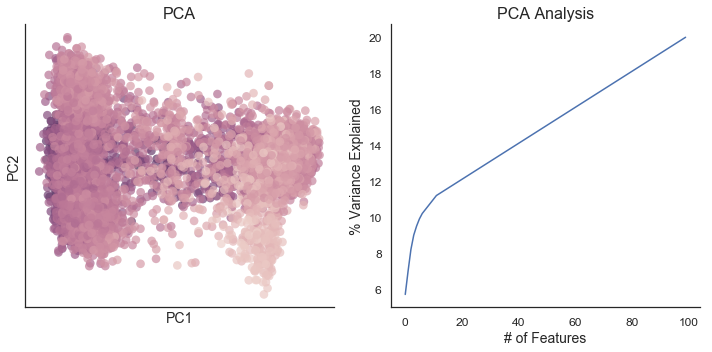

CPU times: user 32.9 s, sys: 5.54 s, total: 38.4 s
Wall time: 30 s


In [9]:
%%time
retina_PCA = fcc_PCA(matrix=retina.arcsinh_norm(norm='l1'), n_components=100)
retina_PCA.plot()

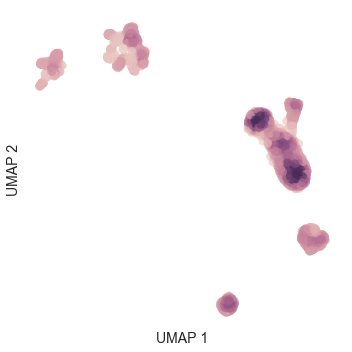

CPU times: user 22.5 s, sys: 1.19 s, total: 23.7 s
Wall time: 23.8 s


In [11]:
%%time
retina_UMAP = fcc_UMAP(matrix=retina_PCA.results,perplexity=30)
retina_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1349639b0>)

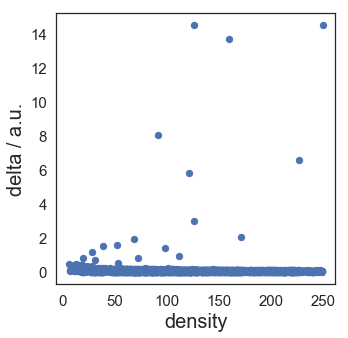

In [12]:
retina_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12d2b1e48>)

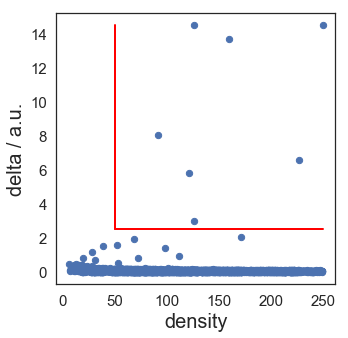

In [15]:
retina_UMAP.clu.assign(50,2.5)
retina_UMAP.clu.draw_decision_graph(min_delta=retina_UMAP.clu.min_delta, min_density=retina_UMAP.clu.min_density)

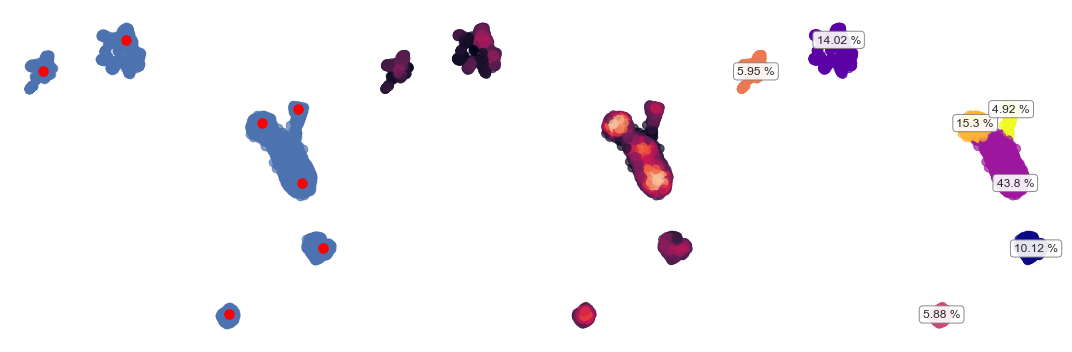

In [16]:
retina_UMAP.plot_clusters()

In [17]:
retina_UMAP.silhouette_score()

0.66710687

In [18]:
retina_ds = RNA_counts.downsample_proportional(retina, clu_membership=retina_UMAP.clu.membership, n_cells=1600, seed=18)

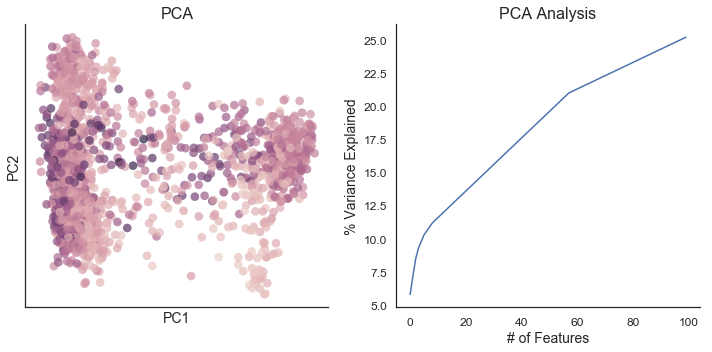

CPU times: user 7.29 s, sys: 922 ms, total: 8.21 s
Wall time: 5.27 s


In [19]:
%%time
retina_ds_PCA = fcc_PCA(matrix=retina_ds.arcsinh_norm(norm='l1'), n_components=100)
retina_ds_PCA.plot()

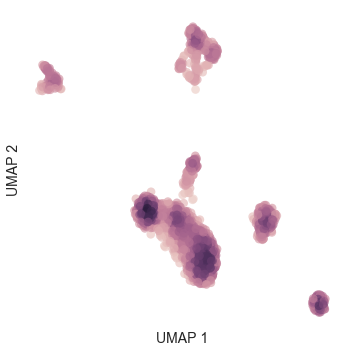

CPU times: user 4.96 s, sys: 307 ms, total: 5.27 s
Wall time: 5.18 s


In [20]:
%%time
retina_ds_UMAP = fcc_UMAP(matrix=retina_ds_PCA.results,perplexity=30)
retina_ds_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1368c3550>)

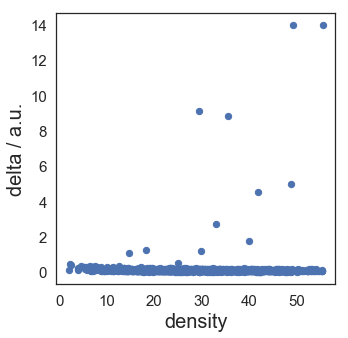

In [21]:
retina_ds_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1368ccef0>)

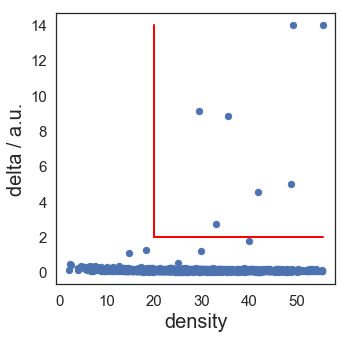

In [22]:
retina_ds_UMAP.clu.assign(20,2)
retina_ds_UMAP.clu.draw_decision_graph(min_delta=retina_ds_UMAP.clu.min_delta, min_density=retina_ds_UMAP.clu.min_density)

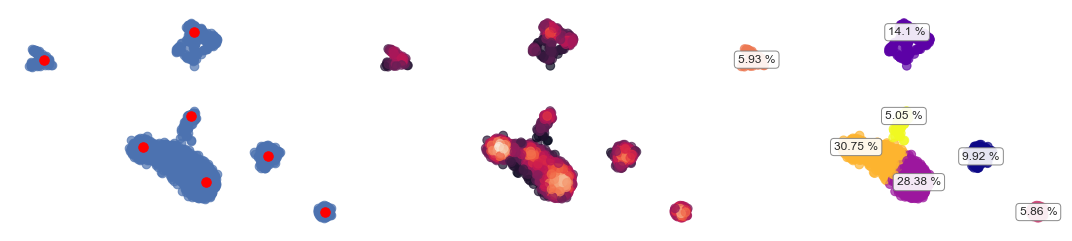

In [23]:
retina_ds_UMAP.plot_clusters()

In [24]:
retina_ds_UMAP.silhouette_score()

0.6496044

In [25]:
retina_ds_UMAP.cluster_counts()

159 cells in cluster 0 (9.919 %)

226 cells in cluster 1 (14.099 %)

455 cells in cluster 2 (28.384 %)

94 cells in cluster 3 (5.864 %)

95 cells in cluster 4 (5.926 %)

493 cells in cluster 5 (30.755 %)

81 cells in cluster 6 (5.053 %)



In [26]:
# set cluster membership as barcodes
retina_ds_UMAP.barcodes = pd.Series(retina_ds_UMAP.clu.membership)

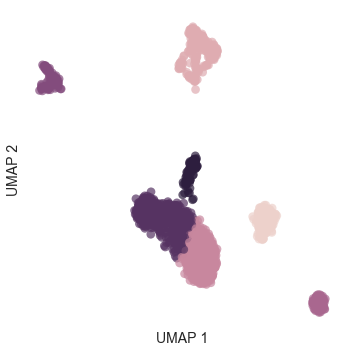

In [27]:
retina_ds_UMAP.plot_barcodes()

In [28]:
# set cluster membership as barcodes
retina_ds.barcodes = pd.Series(retina_ds_UMAP.clu.membership)

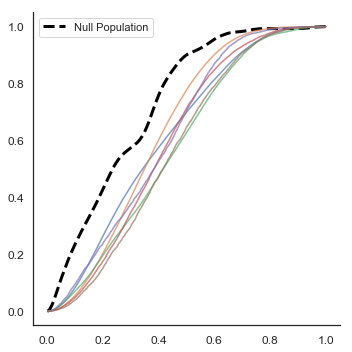

CPU times: user 2.93 s, sys: 197 ms, total: 3.13 s
Wall time: 2.96 s


In [29]:
%%time
# compare each cluster's cell-cell distances to the null population
retina_out = compare_barcode_distances(obj=retina_ds_UMAP, barcodes=[1,2,3,4,5,6])

In [30]:
%%time
# range of top clusters in retina dataset is 400 to 4200 cells. create 'standard curve' of n_cells to determine noise threshold. 
retina_curve = cell_bias_curve(obj=retina_ds_UMAP, pop_sizes=np.arange(80, 500, 20), iter=10)

CPU times: user 1min 18s, sys: 3.41 s, total: 1min 21s
Wall time: 1min 23s


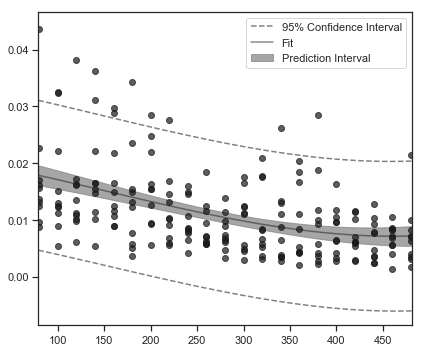

In [31]:
# plot polynomial regression
retina_p, retina_pi, retina_ci = easy_regression(x=retina_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y = retina_curve.melt(id_vars='n_cells')['value'], deg=3)

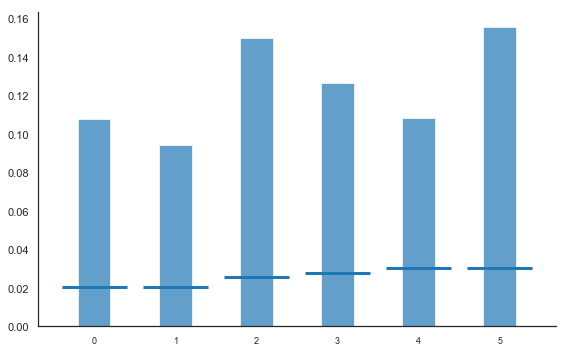

In [32]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(8,5))
plt.bar(x=[0,1,2,3,4,5], height=retina_out.EMD, width=-0.4, color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=retina_p, x=retina_ds.barcode_counts([0,1,2,3,4,5])) + regression_intervals(x=retina_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=retina_curve.melt(id_vars='n_cells')['value'],
                                  p=retina_p, x_range=list(retina_ds.barcode_counts([0,1,2,3,4,5])))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()

---
Now try the same thing for a continuous dataset by assigning random barcodes with proportional downsampling

In [34]:
s1 = RNA_counts.from_file(datafile='resources/qi_s1_edited_all.csv.gz', labels=[None,None])

In [35]:
s1.data.shape

(1595, 25507)

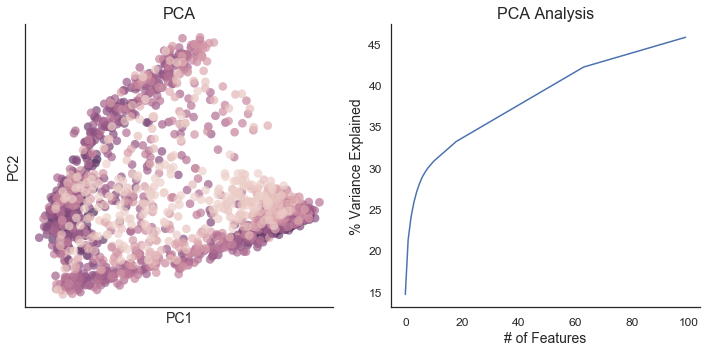

CPU times: user 9.71 s, sys: 1.13 s, total: 10.8 s
Wall time: 7.73 s


In [36]:
%%time
s1_PCA = fcc_PCA(matrix=s1.arcsinh_norm(norm='l1'), n_components=100)
s1_PCA.plot()

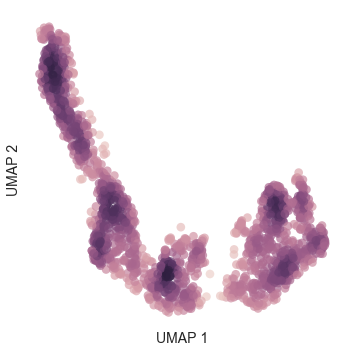

CPU times: user 3.93 s, sys: 233 ms, total: 4.16 s
Wall time: 3.96 s


In [37]:
%%time
s1_UMAP = fcc_UMAP(matrix=s1_PCA.results,perplexity=30)
s1_UMAP.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x137cb85c0>)

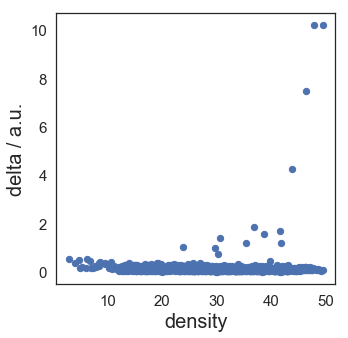

In [38]:
s1_UMAP.clu.draw_decision_graph()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x139b9ae10>)

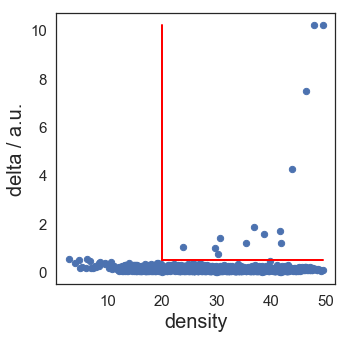

In [39]:
s1_UMAP.clu.assign(20,0.5)
s1_UMAP.clu.draw_decision_graph(min_delta=s1_UMAP.clu.min_delta, min_density=s1_UMAP.clu.min_density)

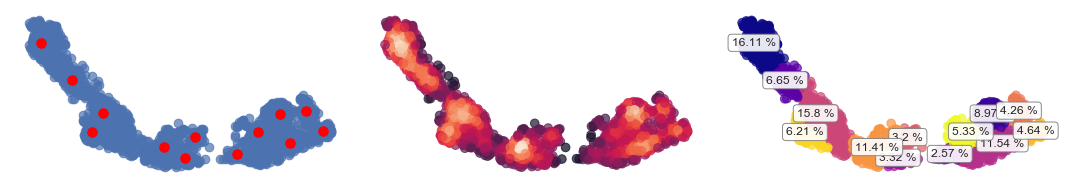

In [40]:
s1_UMAP.plot_clusters()

In [41]:
s1_UMAP.silhouette_score()


0.39407545

In [42]:
s1_200 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=200)
s1_150 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=150)
s1_100 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=100)
s1_50 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=50)
s1_30 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=30)
s1_20 = RNA_counts.downsample_proportional(counts_obj=s1, clu_membership=s1_UMAP.clu.membership, n_cells=20)

In [43]:
s1_codes = np.zeros(s1.data.shape[0])

In [44]:
np.put(s1_codes, s1_200.data.index, 1)
np.put(s1_codes, s1_150.data.index, 2)
np.put(s1_codes, s1_100.data.index, 3)
np.put(s1_codes, s1_50.data.index, 4)
np.put(s1_codes, s1_30.data.index, 5)
np.put(s1_codes, s1_20.data.index, 6)

In [45]:
# set cluster membership as barcodes
s1_UMAP.barcodes = pd.Series(s1_codes, dtype='int')

In [46]:
# set cluster membership as barcodes
s1.barcodes = pd.Series(s1_codes, dtype='int')

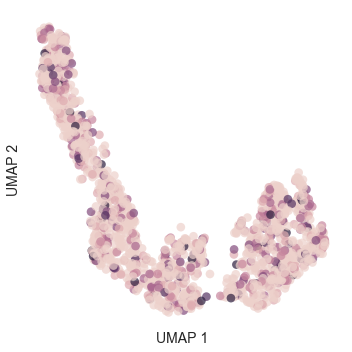

In [47]:
s1_UMAP.plot_barcodes()

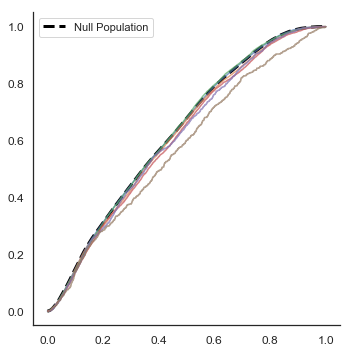

CPU times: user 3.3 s, sys: 235 ms, total: 3.53 s
Wall time: 3.38 s


In [48]:
%%time
# compare each cluster's cell-cell distances to the null population
s1_out = compare_barcode_distances(obj=s1_UMAP, barcodes=[1,2,3,4,5,6])

In [49]:
%%time
# range of top clusters in s1 dataset is 20 to 200 cells. create 'standard curve' of n_cells to determine noise threshold. 
s1_curve = cell_bias_curve(obj=s1_UMAP, pop_sizes=np.arange(20, 200, 10), iter=10)

CPU times: user 1min 8s, sys: 2.3 s, total: 1min 10s
Wall time: 1min 11s


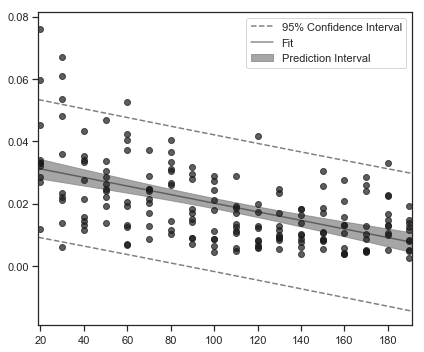

In [50]:
# plot polynomial regression
s1_p, s1_pi, s1_ci = easy_regression(x=s1_curve.melt(id_vars='n_cells')['n_cells'], y=s1_curve.melt(id_vars='n_cells')['value'], deg=1)

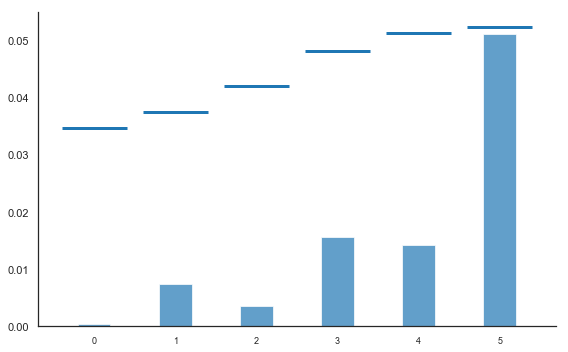

In [51]:
# plot results against acceptance criteria for each dataset (untreated and idling)
plt.figure(figsize=(8,5))
plt.bar(x=[0,1,2,3,4,5], height=s1_out.EMD, width=-0.4, color='#1f77b4', alpha=0.7)
plt.hlines(y=np.polyval(p=s1_p, x=s1.barcode_counts([1,2,3,4,5,6])) + regression_intervals(x=s1_curve.melt(id_vars='n_cells')['n_cells'], 
                                  y=s1_curve.melt(id_vars='n_cells')['value'],
                                  p=s1_p, x_range=list(s1.barcode_counts([1,2,3,4,5,6])))[0], 
           xmin=np.arange(0,36)-0.4, xmax=np.arange(0,37)+0.4, linewidth=3, color='#1f77b4')
plt.xticks(fontsize=9)
sns.despine()
plt.tight_layout()
plt.show()